In [9]:
import torch
import torch.nn as nn
from model.pspnet import PSPNet
import cv2
import numpy as np

def check_data_types(model, input_tensor):
    def forward_hook(module, input, output):
        if len(input) > 0:
            input_type = input[0].dtype
        else:
            input_type = None
        output_type = output.dtype
        print(f"{module.__class__.__name__} - Input type: {input_type}, Output type: {output_type}")
    
    handles = []
    for layer in model.children():
        handle = layer.register_forward_hook(forward_hook)
        handles.append(handle)
    
    model(input_tensor)
    
    for handle in handles:
        handle.remove()

model = PSPNet(num_classes=4, dropout_p=0.5, use_aux=True)
input_a = cv2.imread("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/SEM_DATA/chged_images_256_a50_c80/Image1 - 001_0_0.jpg")
input_b = cv2.imread("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/SEM_DATA/chged_images_256_a50_c80/Image1 - 001_0_4.jpg")
input_n = np.stack((input_a, input_b), axis=0)
input_tensor = torch.tensor(input_n)
input_tensor = input_tensor.permute(0, 3, 1, 2).float()

check_data_types(model, input_tensor)

Sequential - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Dropout2d - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Dropout2d - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Dropout2d - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Dropout2d - Input type: torch.float32, Output type: torch.float32
PSPModule - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32
Sequential - Input type: torch.float32, Output type: torch.float32


### 数据长尾程度分析

#### Image

基本统计信息:
直方图区间数: 256
总像素数: 3620864.0
最大频率: 144675.0
最小频率: 0.0
平均频率: 14144.00
频率标准差: 29141.82

分布指标:
基尼系数: 0.7223
熵值: 6.4052
帕累托比例: 0.7747


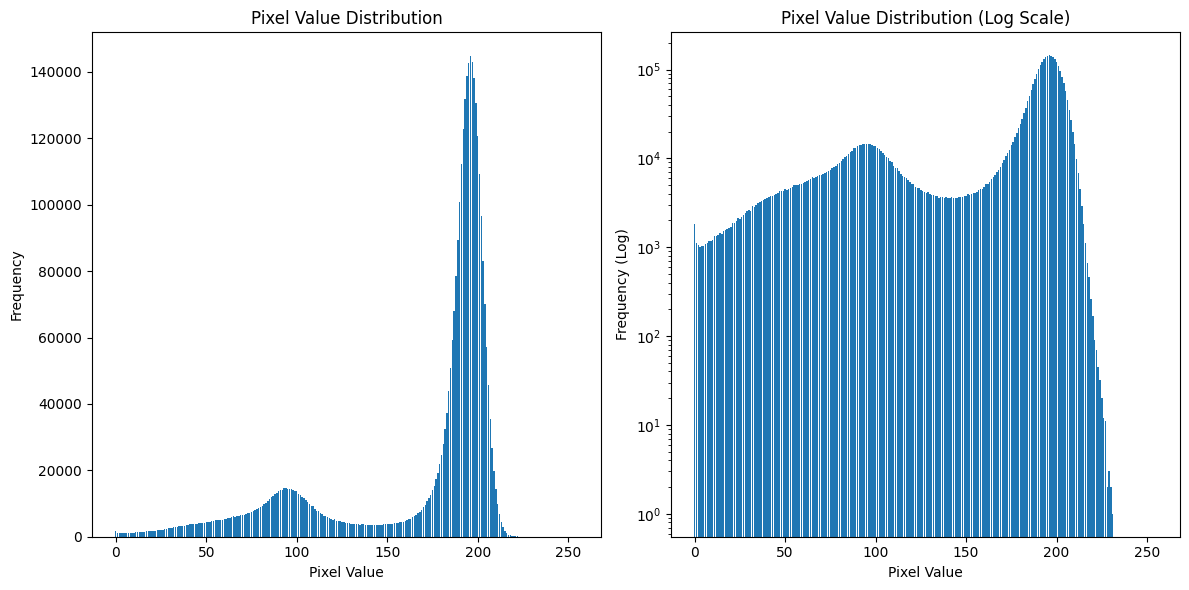

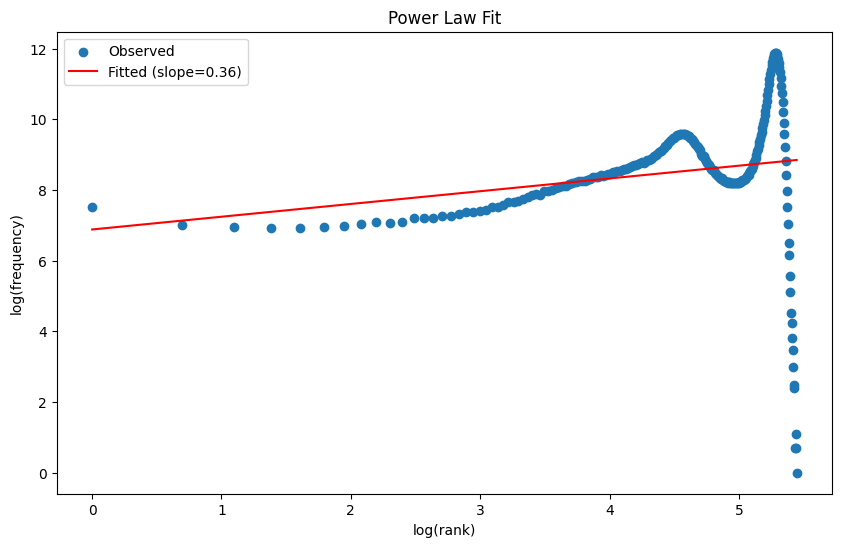


幂律分布拟合结果:
斜率: 0.3609
R²: 0.0354
p值: 0.0040

分位数统计:
10th percentile: 32462.0
25th percentile: 9931.0
50th percentile: 4515.0
75th percentile: 1853.0
90th percentile: 2.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cv2

def analyze_image_distribution(image):
    """分析图像像素值分布"""
    
    # 确保图像是一维数组
    flattened_image = image.flatten()
    
    # 计算像素值的直方图
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.flatten()
    
    # 1. 基本统计信息
    n_bins = len(hist)
    total_pixels = np.sum(hist)
    
    print("基本统计信息:")
    print(f"直方图区间数: {n_bins}")
    print(f"总像素数: {total_pixels}")
    print(f"最大频率: {np.max(hist)}")
    print(f"最小频率: {np.min(hist)}")
    print(f"平均频率: {np.mean(hist):.2f}")
    print(f"频率标准差: {np.std(hist):.2f}")
    
    # 2. 计算分布指标
    # 基尼系数
    sorted_hist = np.sort(hist)
    cumsum = np.cumsum(sorted_hist)
    gini = (np.sum((2 * np.arange(1, len(hist) + 1) - len(hist) - 1) 
            * sorted_hist)) / (len(hist) * np.sum(sorted_hist))
    
    # 熵值
    probs = hist / total_pixels
    entropy = -np.sum(probs * np.log2(probs + 1e-10))
    
    # 前20%像素值包含的像素比例
    sorted_hist_desc = np.sort(hist)[::-1]
    top_20_percent = int(np.ceil(len(hist) * 0.2))
    pareto_ratio = np.sum(sorted_hist_desc[:top_20_percent]) / total_pixels
    
    print("\n分布指标:")
    print(f"基尼系数: {gini:.4f}")
    print(f"熵值: {entropy:.4f}")
    print(f"帕累托比例: {pareto_ratio:.4f}")
    
    # 3. 绘制分布图
    plt.figure(figsize=(12, 6))
    
    # 基础分布图
    plt.subplot(121)
    plt.bar(range(len(hist)), hist)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # 对数尺度图
    plt.subplot(122)
    plt.bar(range(len(hist)), hist)
    plt.yscale('log')
    plt.title('Pixel Value Distribution (Log Scale)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency (Log)')
    
    plt.tight_layout()
    plt.show()
    
    # 4. 拟合幂律分布
    # 去除零频率
    non_zero_hist = hist[hist > 0]
    x = np.arange(1, len(non_zero_hist) + 1)
    
    # 对数转换
    log_x = np.log(x)
    log_y = np.log(non_zero_hist)
    
    # 线性拟合
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)
    
    # 绘制拟合结果
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, label='Observed')
    plt.plot(log_x, slope * log_x + intercept, 'r', 
            label=f'Fitted (slope={slope:.2f})')
    plt.xlabel('log(rank)')
    plt.ylabel('log(frequency)')
    plt.title('Power Law Fit')
    plt.legend()
    plt.show()
    
    print("\n幂律分布拟合结果:")
    print(f"斜率: {slope:.4f}")
    print(f"R²: {r_value**2:.4f}")
    print(f"p值: {p_value:.4f}")
    
    # 5. 分位数统计
    sorted_hist_desc = np.sort(hist)[::-1]
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    print("\n分位数统计:")
    for q in quantiles:
        index = int(len(sorted_hist_desc) * q)
        print(f"{int(q*100)}th percentile: {sorted_hist_desc[index]}")
    
    return {
        'basic_stats': {
            'n_bins': n_bins,
            'total_pixels': total_pixels,
            'max_freq': np.max(hist),
            'min_freq': np.min(hist),
            'mean_freq': np.mean(hist),
            'std_freq': np.std(hist)
        },
        'distribution_metrics': {
            'gini': gini,
            'entropy': entropy,
            'pareto_ratio': pareto_ratio
        },
        'power_law_metrics': {
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value
        }
    }

# 使用示例
image = cv2.imread("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/Image1 - 003.jpeg", cv2.IMREAD_GRAYSCALE)
results = analyze_image_distribution(image)

#### Label

基本统计信息:
类别数量: 4
总样本数: 3620864
最大类别样本数: 2767816
最小类别样本数: 18401
平均每类样本数: 905216.00
样本数标准差: 1104865.60

不平衡指标:
不平衡比率: 150.4166
基尼系数: 0.6075
熵值: 0.9750
帕累托比例: 0.7644


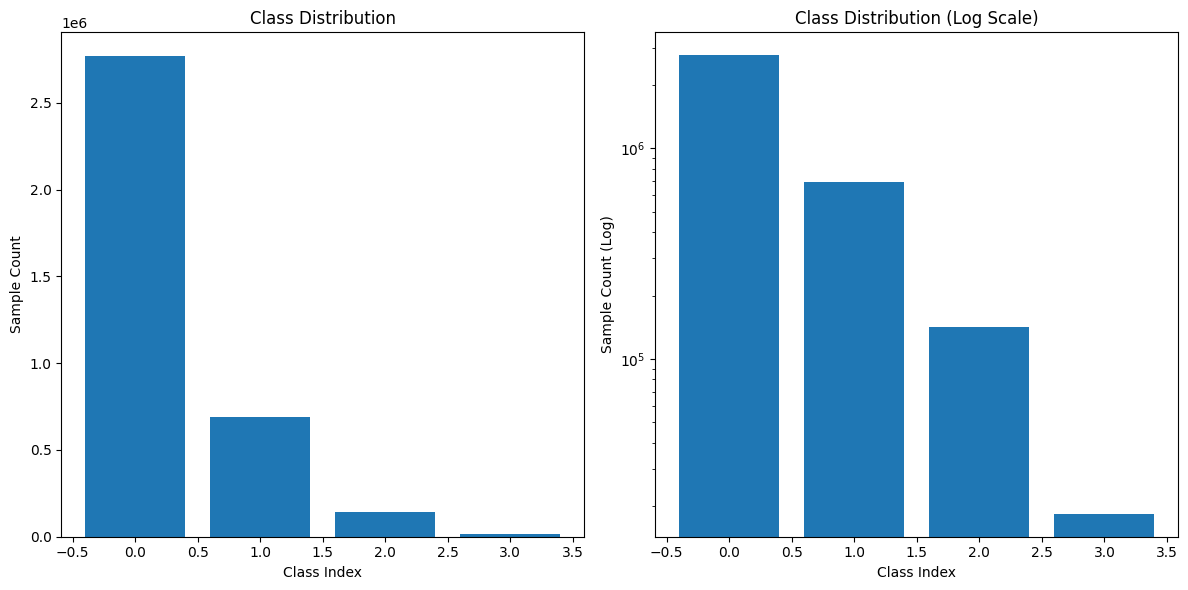

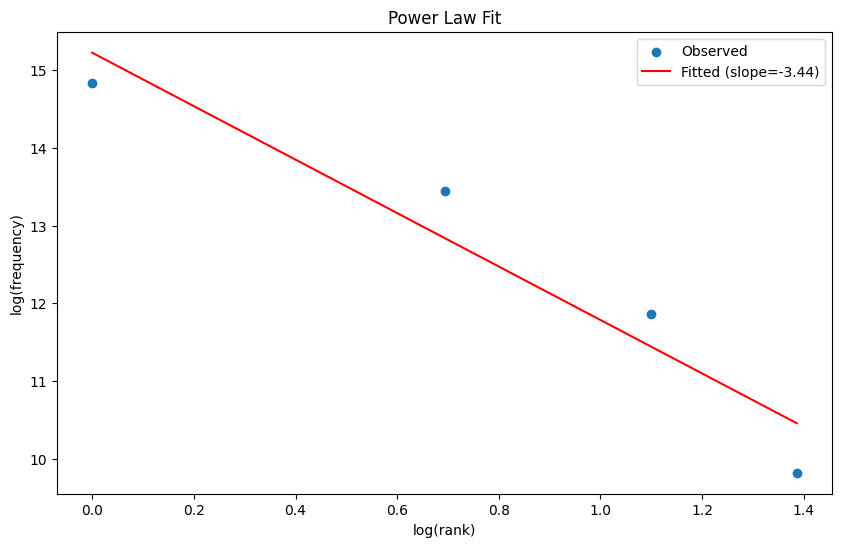


幂律分布拟合结果:
斜率: -3.4390
R²: 0.9208
p值: 0.0404

分位数统计:
10th percentile: 2767816
25th percentile: 692200
50th percentile: 142447
75th percentile: 18401
90th percentile: 18401


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_label_distribution(labels):
    """分析标签分布"""
    
    # 确保标签是一维数组
    labels = np.array(labels).flatten()
    
    # 计算每个类别的样本数量
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    
    # 1. 基本统计信息
    n_classes = len(class_counts)
    
    print("基本统计信息:")
    print(f"类别数量: {n_classes}")
    print(f"总样本数: {total_samples}")
    print(f"最大类别样本数: {np.max(class_counts)}")
    print(f"最小类别样本数: {np.min(class_counts)}")
    print(f"平均每类样本数: {np.mean(class_counts):.2f}")
    print(f"样本数标准差: {np.std(class_counts):.2f}")
    
    # 2. 计算不平衡指标
    # 不平衡比率 (Imbalance Ratio, IR)
    ir = np.max(class_counts) / np.min(class_counts)
    
    # 基尼系数 (Gini Coefficient)
    sorted_counts = np.sort(class_counts)
    cumsum = np.cumsum(sorted_counts)
    gini = (np.sum((2 * np.arange(1, len(class_counts) + 1) - len(class_counts) - 1) 
            * sorted_counts)) / (len(class_counts) * np.sum(sorted_counts))
    
    # 熵值 (Entropy)
    probs = class_counts / total_samples
    entropy = -np.sum(probs * np.log2(probs + 1e-10))
    
    # 类别占比前20%的样本总量占比
    sorted_counts_desc = np.sort(class_counts)[::-1]
    top_20_percent = int(np.ceil(len(class_counts) * 0.2))
    pareto_ratio = np.sum(sorted_counts_desc[:top_20_percent]) / total_samples
    
    print("\n不平衡指标:")
    print(f"不平衡比率: {ir:.4f}")
    print(f"基尼系数: {gini:.4f}")
    print(f"熵值: {entropy:.4f}")
    print(f"帕累托比例: {pareto_ratio:.4f}")
    
    # 3. 绘制分布图
    plt.figure(figsize=(12, 6))
    
    # 基础分布图
    plt.subplot(121)
    plt.bar(range(len(class_counts)), class_counts)
    plt.title('Class Distribution')
    plt.xlabel('Class Index')
    plt.ylabel('Sample Count')
    
    # 对数尺度图
    plt.subplot(122)
    plt.bar(range(len(class_counts)), class_counts)
    plt.yscale('log')
    plt.title('Class Distribution (Log Scale)')
    plt.xlabel('Class Index')
    plt.ylabel('Sample Count (Log)')
    
    plt.tight_layout()
    plt.show()
    
    # 4. 拟合幂律分布
    # 去除零频率
    non_zero_counts = class_counts[class_counts > 0]
    x = np.arange(1, len(non_zero_counts) + 1)
    
    # 对数转换
    log_x = np.log(x)
    log_y = np.log(non_zero_counts)
    
    # 线性拟合
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)
    
    # 绘制拟合结果
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, label='Observed')
    plt.plot(log_x, slope * log_x + intercept, 'r', 
            label=f'Fitted (slope={slope:.2f})')
    plt.xlabel('log(rank)')
    plt.ylabel('log(frequency)')
    plt.title('Power Law Fit')
    plt.legend()
    plt.show()
    
    print("\n幂律分布拟合结果:")
    print(f"斜率: {slope:.4f}")
    print(f"R²: {r_value**2:.4f}")
    print(f"p值: {p_value:.4f}")
    
    # 5. 分位数统计
    sorted_counts_desc = np.sort(class_counts)[::-1]
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    print("\n分位数统计:")
    for q in quantiles:
        index = int(len(sorted_counts_desc) * q)
        print(f"{int(q*100)}th percentile: {sorted_counts_desc[index]}")
    
    return {
        'basic_stats': {
            'n_classes': n_classes,
            'total_samples': total_samples,
            'max_samples': np.max(class_counts),
            'min_samples': np.min(class_counts),
            'mean_samples': np.mean(class_counts),
            'std_samples': np.std(class_counts)
        },
        'imbalance_metrics': {
            'imbalance_ratio': ir,
            'gini_coefficient': gini,
            'entropy': entropy,
            'pareto_ratio': pareto_ratio
        },
        'power_law_metrics': {
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value
        }
    }

# 使用示例
labels = cv2.imread("/mnt/e/VScode/WS-Hub/WS-U2net/U-2-Net/Image1 - 003.png", cv2.IMREAD_GRAYSCALE)
results = analyze_label_distribution(labels)